In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import DataSplitter
import utils
from sklearn.preprocessing import StandardScaler
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df60 = DataSplitter.getTrainData(60)

df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)
#df60_line = df60_line.set_index(pd.RangeIndex(start=0, stop=df60_line.shape[0]))

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

# Recursive

Docs https://skforecast.org/0.11.0/user_guides/autoregresive-forecaster.html

Example https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

SHAP https://skforecast.org/0.11.0/user_guides/explainability.html

In [50]:
target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

In [51]:
model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 20, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

forecaster.fit(y=y_train, exog=X_train)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=35,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [  1  20 120 140] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 141 
Weight function included: False 
Differentiation order: 1 
Exogenous included: True 
Type of exogenous variable: <cl

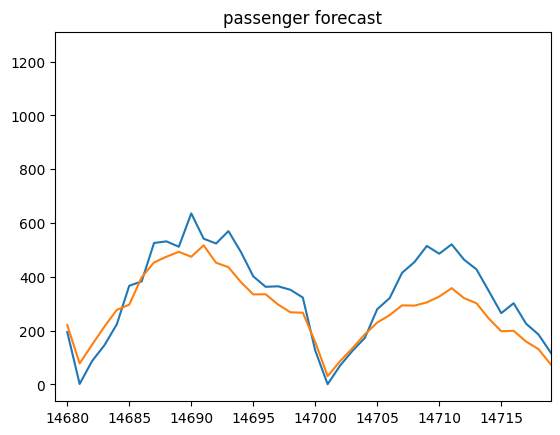

In [52]:
y_train_pred = forecaster.predict(steps=40, exog=X_val[:40])
y_train_pred
plt.plot(X_val.index, val60_line['passengersBoarding'])
plt.plot(X_val.index[:40], y_train_pred)
plt.xlim([14679, 14679+40])
plt.title('passenger forecast')
plt.show()

In [62]:
X_train['lag_1'] = y_train.shift(periods=1).fillna(0)
X_train['lag_20'] = y_train.shift(periods=20).fillna(0)
X_train['lag_120'] = y_train.shift(periods=120).fillna(0)
X_train['lag_140'] = y_train.shift(periods=140).fillna(0)
model.fit(X_train, y_train)

explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

PermutationExplainer explainer: 14681it [03:36, 64.58it/s]                           


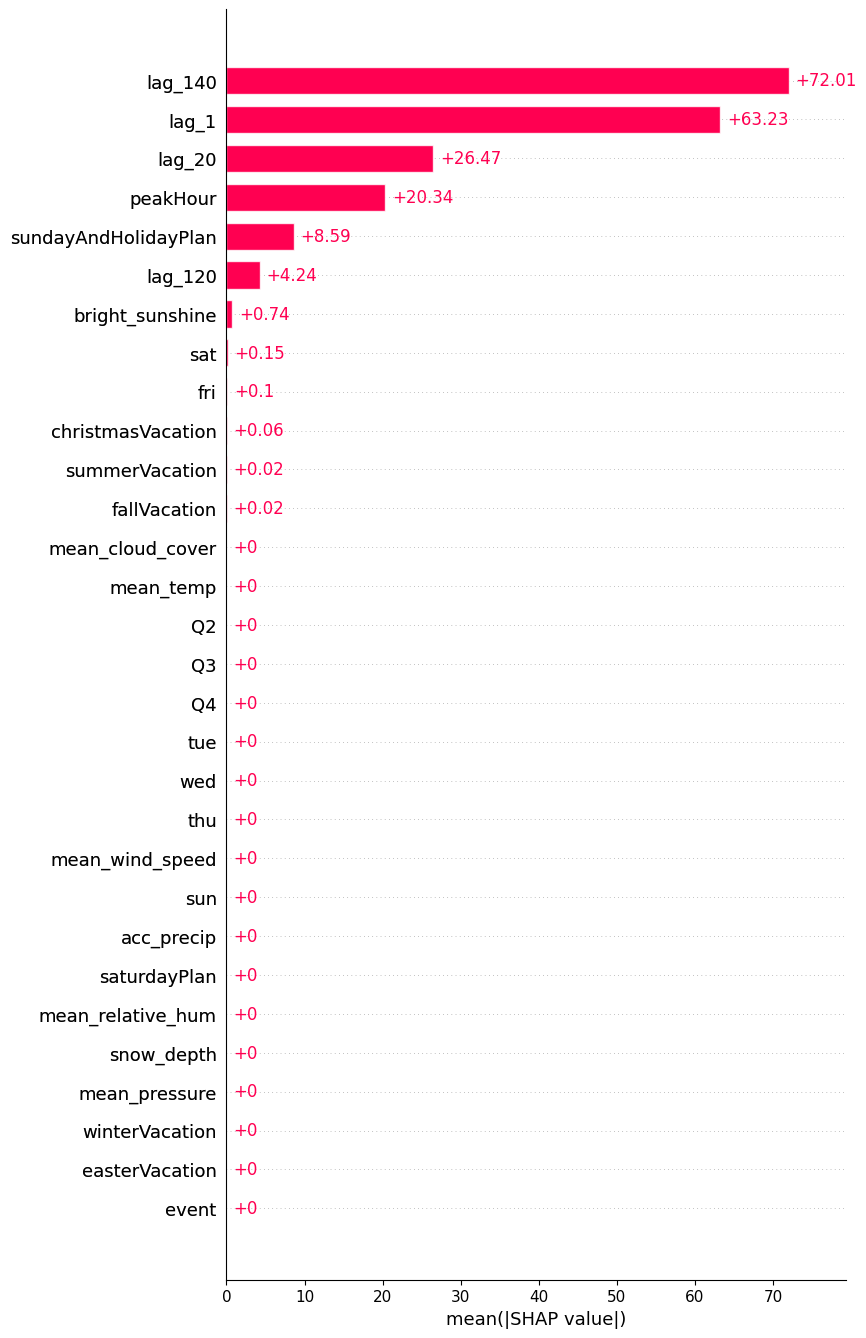

In [64]:
shap.plots.bar(shap_values, max_display=52)

# Direct

In [65]:
target = 'diff'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime']

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

# scale and keep column names
scalar = StandardScaler()
X_train_scaled = pd.DataFrame()
X_val_scaled = pd.DataFrame()
X_train_scaled[X_train.columns] = scalar.fit_transform(X_train[X_train.columns])
X_val_scaled[X_val.columns] = scalar.transform(X_val[X_val.columns])

In [66]:
# grid search for best val mae%
best_val_mae = 100000
best_model = None
for estimators in [2, 5, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for depth in [2, 3, 4, 5, 7, 9]:
        for lr in [0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001]:
            model = xgb.XGBRegressor(n_estimators=estimators, max_depth=depth, eta=lr, seed=42)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_val_pred = model.predict(X_val_scaled)
            
            # cumsum predictions to produce passengers
            period = 20
            y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
            #y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)
            # experimental correction
            val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
            y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
            y_val_pred_passengers = val60_line_extended + y_val_pred_extended
            
            val_mae = utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_mape = utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_rmse = utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers)
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                best_model = model
                print(estimators, depth, lr, val_mae, val_mape, val_rmse)

best_model.feature_names = list(X_train.columns)

2 2 0.5 0.263 nan 0.337
2 2 0.3 0.212 nan 0.294
2 2 0.25 0.2 nan 0.29
2 2 0.2 0.193 nan 0.291
2 2 0.15 0.19 nan 0.296
2 3 0.15 0.188 nan 0.284
2 4 0.15 0.187 nan 0.283
2 7 0.25 0.185 nan 0.261
2 7 0.2 0.184 nan 0.268
5 3 0.1 0.18 nan 0.266
5 4 0.3 0.179 nan 0.245
5 4 0.25 0.176 nan 0.24
5 5 0.2 0.175 nan 0.24
8 4 0.2 0.173 nan 0.233
8 4 0.1 0.171 nan 0.244
10 4 0.1 0.169 nan 0.237
15 5 0.1 0.167 nan 0.227
20 3 0.1 0.166 nan 0.227
25 4 0.05 0.165 nan 0.231
35 4 0.05 0.164 nan 0.225


In [67]:
# fit best model
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# transform from diff to passengers by 1 step past
#y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_train_pred
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_val_pred

# by previous 40 step cumsum
period = 40
y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)

# correction for first 40 obs
val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

print('training MAE%', utils.MAE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAE%', utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training MAPE', utils.MAPE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAPE', utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training RMSE%', utils.RMSE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation RMSE%', utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers))

training MAE% 0.265 validation MAE% 0.196
training MAPE 0.504 validation MAPE nan
training RMSE% 0.35 validation RMSE% 0.265


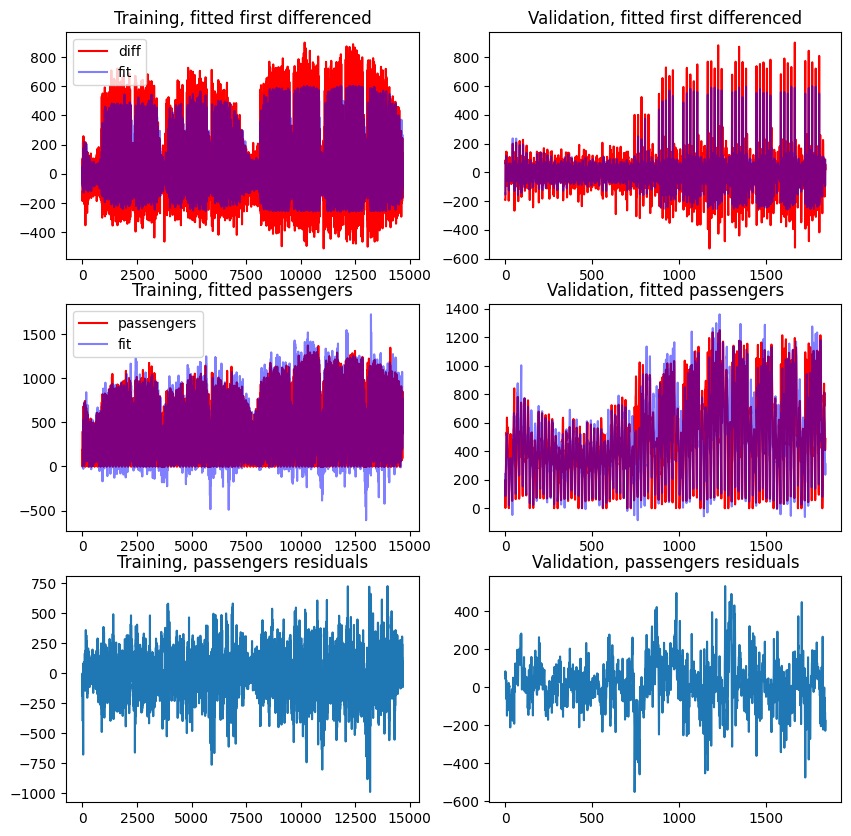

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0, 0].plot(y_train.index, y_train.values, color='red', label='diff')
ax[0, 0].plot(y_train.index, y_train_pred, color='blue', alpha=0.5, label='fit')
ax[0, 0].set_title('Training, fitted first differenced')
ax[0, 0].legend()

ax[1, 0].plot(X_train.index, train60_line['passengersBoarding'], color='red', label='passengers')
ax[1, 0].plot(X_train.index, y_train_pred_passengers, color='blue', alpha=0.5, label='fit')
ax[1, 0].set_title('Training, fitted passengers')
ax[1, 0].legend()

ax[2, 0].plot(X_train.index, y_train_pred_passengers - train60_line['passengersBoarding'].values)
ax[2, 0].set_title('Training, passengers residuals')

ax[0, 1].plot(y_val.index, y_val.values, color='red')
ax[0, 1].plot(y_val.index, y_val_pred, color='blue', alpha=0.5)
ax[0, 1].set_title('Validation, fitted first differenced')

ax[1, 1].plot(X_val.index, val60_line['passengersBoarding'], color='red')
ax[1, 1].plot(X_val.index, y_val_pred_passengers, color='blue', alpha=0.5)
ax[1, 1].set_title('Validation, fitted passengers')

ax[2, 1].plot(X_val.index, y_val_pred_passengers - val60_line['passengersBoarding'].values)
ax[2, 1].set_title('Validation, passengers residuals')

plt.show()

['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth', 'event', 'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10', 'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20', 'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']


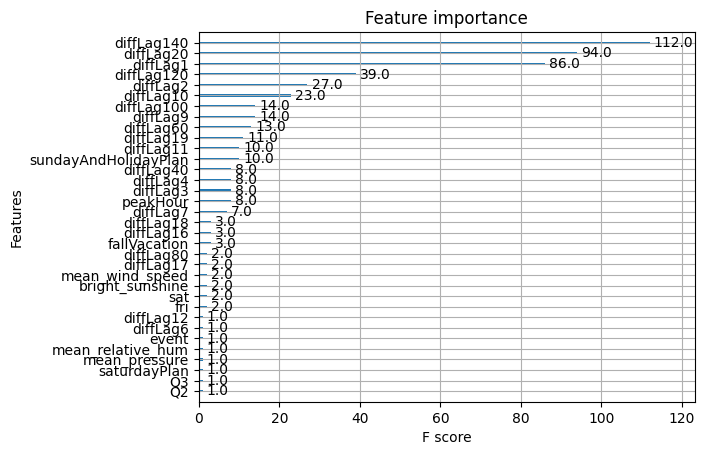

<Axes: title={'center': 'gain'}>

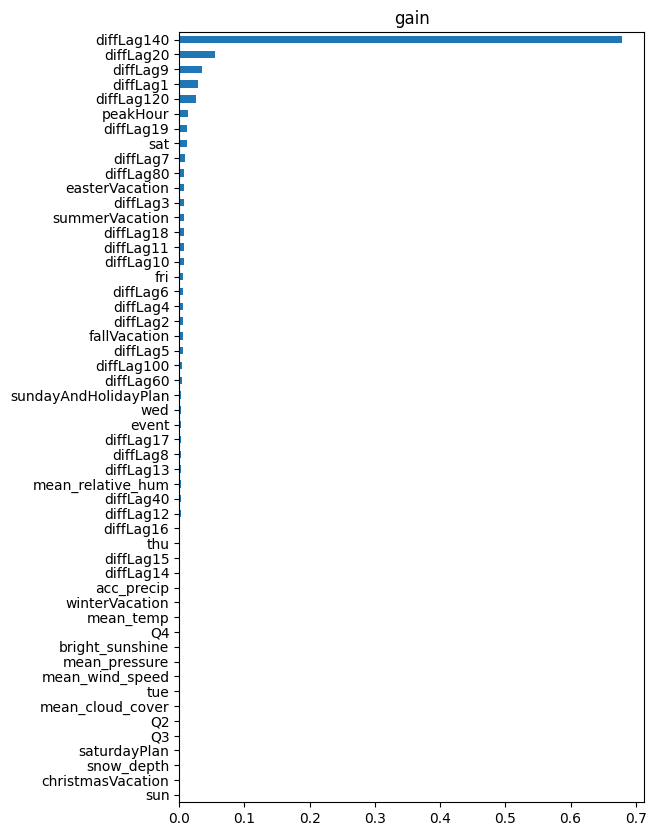

In [69]:
# feature importance
print(best_model.feature_names)

fig, ax = plt.subplots(1)
xgb.plot_importance(best_model, ax=ax)
plt.show()

importances = model.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values().plot.barh(figsize=(6, 10), title='gain')

In [70]:
explainer = shap.Explainer(best_model.predict, X_train_scaled)
shap_values = explainer(X_train_scaled)

PermutationExplainer explainer: 14681it [03:58, 58.89it/s]                           


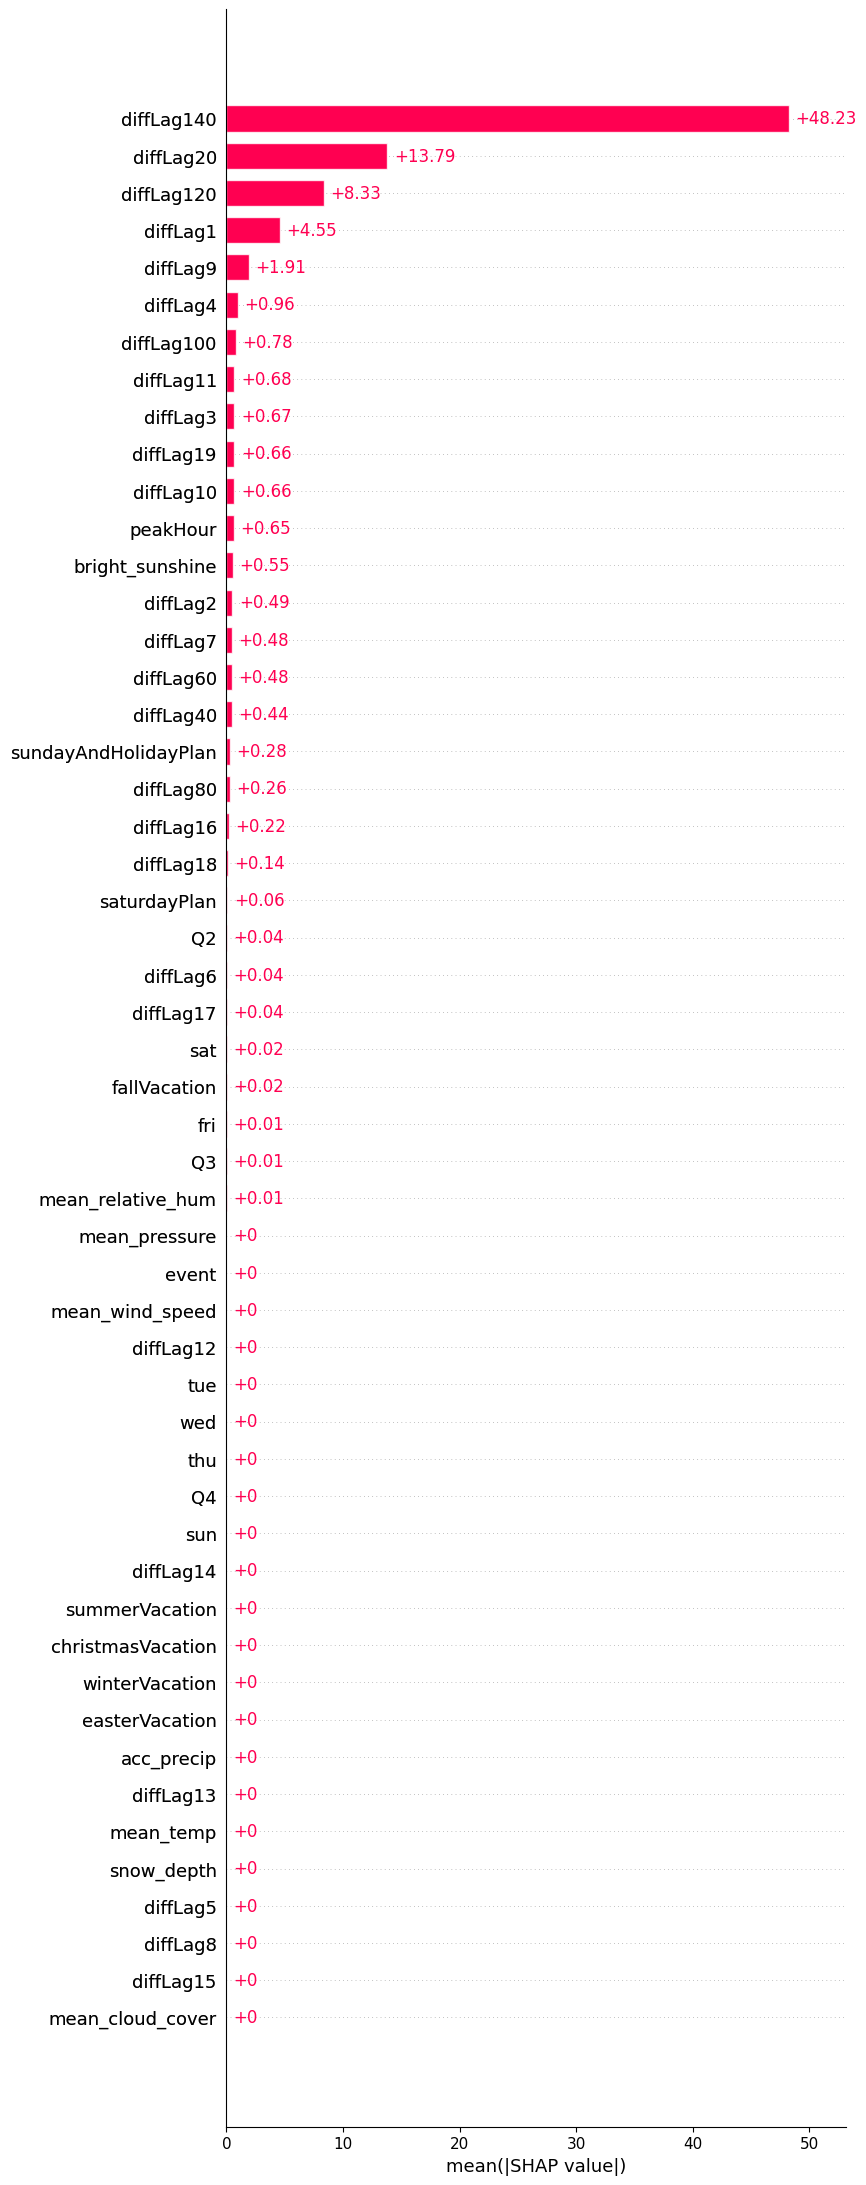

In [72]:
shap.plots.bar(shap_values, max_display=52)